# 1D Wave Equation with Dirichlet boundary conditions

Let's solve this 1-dimensional wave equation:

```math
\begin{align*}
∂^2_t u(x, t) = c^2 ∂^2_x u(x, t) \quad & \textsf{for all } 0 < x < 1 \text{ and } t > 0 \, , \\
u(0, t) = u(1, t) = 0 \quad & \textsf{for all } t > 0 \, , \\
u(x, 0) = x (1-x)     \quad & \textsf{for all } 0 < x < 1 \, , \\
∂_t u(x, 0) = 0       \quad & \textsf{for all } 0 < x < 1 \, , \\
\end{align*}
```

with grid discretization `dx = 0.1` and physics-informed neural networks.

Further, the solution of this equation with the given boundary conditions is presented.


In [1]:
using NeuralPDE, Lux, Optimization, OptimizationOptimJL
using ModelingToolkit, IntervalSets, Plots, LinearAlgebra, JLD2
using QuadGK, Printf


In [2]:

@parameters t, x
@variables u(..)
Dxx = Differential(x)^2
Dtt = Differential(t)^2
Dt = Differential(t)

#2D PDE
C = 1.0
A = 1.0

# Space and time domains
tmin = 0.0
tmax = 10.0
xmin = 0.0
xmax = 5.0

domains = [t ∈ Interval(tmin, tmax),
    x ∈ Interval(xmin, xmax)]
# Discretization
dx = 0.1

eq = Dtt(u(t, x)) ~ C^2 * Dxx(u(t, x))

# Initial and boundary conditions
bcs = [u(t, xmin) ~ 0.0,# for all t > 0
    u(t, xmax) ~ 0.0,# for all t > 0
    u(0, x) ~ -A*(x - xmin)^4 * (x - xmax)^4 / ((xmax - xmin)/2)^8, #for all xmin < x < xmax
    Dt(u(0, x)) ~ 0.0] #for all  0 < x < 1]



# Neural network
chain = Chain(Dense(2, 16, σ), Dense(16, 16, σ), Dense(16, 1))
discretization = PhysicsInformedNN(chain, GridTraining(dx))

@named pde_system = PDESystem(eq, bcs, domains, [t, x], [u(t, x)])
prob = discretize(pde_system, discretization)

loss = Float64[]
callback = function (p, l)
    println("Current loss is: $l")
    push!(loss, l)
    return false
end

# optimizer
opt = OptimizationOptimJL.BFGS()
res = Optimization.solve(prob, opt; callback, maxiters = 12000)
phi = discretization.phi

Current loss is: 0.3066976380401762
Current loss is: 0.20795412914955483
Current loss is: 0.18763416933775381
Current loss is: 0.17942558963869068
Current loss is: 0.17635031045998156
Current loss is: 0.17296012023818794
Current loss is: 0.16941523419514953
Current loss is: 0.16760686350213466
Current loss is: 0.1656102430568377
Current loss is: 0.1621671678725
Current loss is: 0.14226017981818548
Current loss is: 0.12723501976546636
Current loss is: 0.12454136531592394
Current loss is: 0.12122588305460394
Current loss is: 0.11232180389689816
Current loss is: 0.09896260362544934
Current loss is: 0.09598541116392872
Current loss is: 0.09268751679910614
Current loss is: 0.08768948957820079
Current loss is: 0.08273461967680161
Current loss is: 0.08023044391661768
Current loss is: 0.0753378179502103
Current loss is: 0.06418267721466539
Current loss is: 0.05756811431180749
Current loss is: 0.05367558124178301
Current loss is: 0.05163693772988467
Current loss is: 0.05078868573204577
Current 

NeuralPDE.Phi{StatefulLuxLayer{Static.True, Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}, Nothing, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}}(StatefulLuxLayer{Static.True, Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}, Nothing, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}(Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static

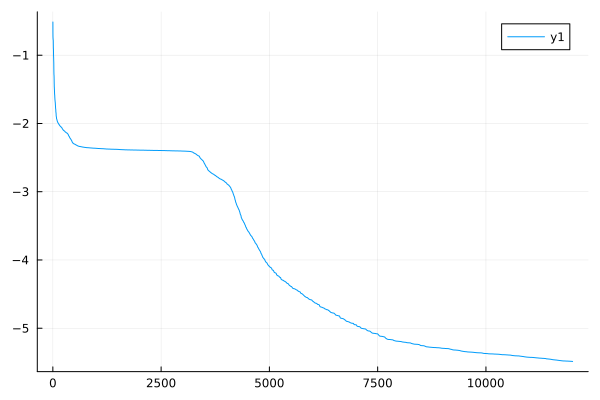

In [3]:
plot(log10.(loss))

In [ ]:
xs = collect(xmin:dx:xmax)
t = 10.0

@show size(xs), size(t_fix)
# plot at a given time:

u_predict = [first(phi([t, x], res.u)) for x in xs]
u_exact = [-A*(x-xmin)^4*(x-xmax)^4 for x in xs]

plot(xs, u_predict, xlabel="x", ylabel="u", title="t = $t", legend=false)
plot!(xs, u_exact, linestyle=:dash, label="Exact Solution")

In [ ]:
plot(xs, u_predict - u_exact , xlabel="x", ylabel="u", title="t = $t", label="error")

In [ ]:
Error = norm(u_predict - u_exact, Inf)

The error at t = 10 with max_iter = 12_000 is 0.039374747599917576

The loss value is: 

In [ ]:
@save "wave_dirichlet_1D_Neural_MI12kGT.jld2" res phi loss Error

In [ ]:

ts = collect(tmin:dx:tmax)
xs = collect(xmin:dx:xmax)

#t = 10.0
#ts = fill(t, length(xs))
"""
This is the analytic solution for the wave equation with Dirichlet boundary conditions
and initial condition u(0,x) = -(x-xmin) * (x-xmax) in the domain [0,L], and u_t(0,x) = 0.
"""

function analytic_sol_func_linear_data(t, x, L)
    sum([(8 / (k^3 * pi^3)/L^3) * sin(k * pi * x / L) * cos(C * k * pi * t / L) for k in 1:2:50000])
end

# Function to expand
f(x) = -x^4 * (x - 1)^4

# Compute the nth Fourier sine coefficient
function bn(n,L)
    integrand(x) = f(x) * sin(n * π * x / L)
    return 2 * quadgk(integrand, 0, 1)[1]
end

function analytic_sol_func_quartic_data(t, x, L)
    bn_list = [bn(k,xmax - xmin) for k in 1:2:50]
    sum([(8 / (k^3 * pi^3)/L^3) * sin(k * pi * x / L) * cos(C * k * pi * t / L) for k in 1:2:50])
end

u_predict = reshape([first(phi([t, x], res.u)) for t in ts for x in xs],
    (length(ts), length(xs)))
u_real = A * reshape([analytic_sol_func_quartic_data(t, x, xmax - xmin) for t in ts for x in xs],
    (length(ts), length(xs)))

diff_u = abs.(u_predict .- u_real)
#p1 = plot(ts, xs, u_real, linetype = :contourf, title = "analytic");
p2 = plot(xs, ts, u_predict, linetype = :contourf, title = "predict");
#p3 = plot(ts, xs, diff_u, linetype = :contourf, title = "error");

plot(p1, p2, p3)


In [ ]:
using QuadGK, Printf

# Function to expand
f(x) = -x^4 * (x - 1)^4

# Compute the nth Fourier sine coefficient
function bn(n,L)
    integrand(x) = f(x) * sin(n * π * x / L)
    return 2 * quadgk(integrand, 0, 1)[1]
end

# Print first 10 coefficients
for n in 1:10
    @printf("b_%d = %.8e\n", n, bn(n,1))
end